In [1]:
options(jupyter.plot_mimetypes = 'image/png')
options(repr.plot.width=23.6, repr.plot.height=9.1, repr.plot.res=300)

In [2]:
library(data.table)
library(ggplot2)

In [3]:
solstice_jun <- as.numeric(format(as.POSIXct("2016-06-20 22:34:00", format="%Y-%m-%d %H:%M:%S", tz=""), "%j"))
solstice_dec <- as.numeric(format(as.POSIXct("2016-12-21 10:44:00", format="%Y-%m-%d %H:%M:%S", tz=""), "%j"))

pdf 
  2

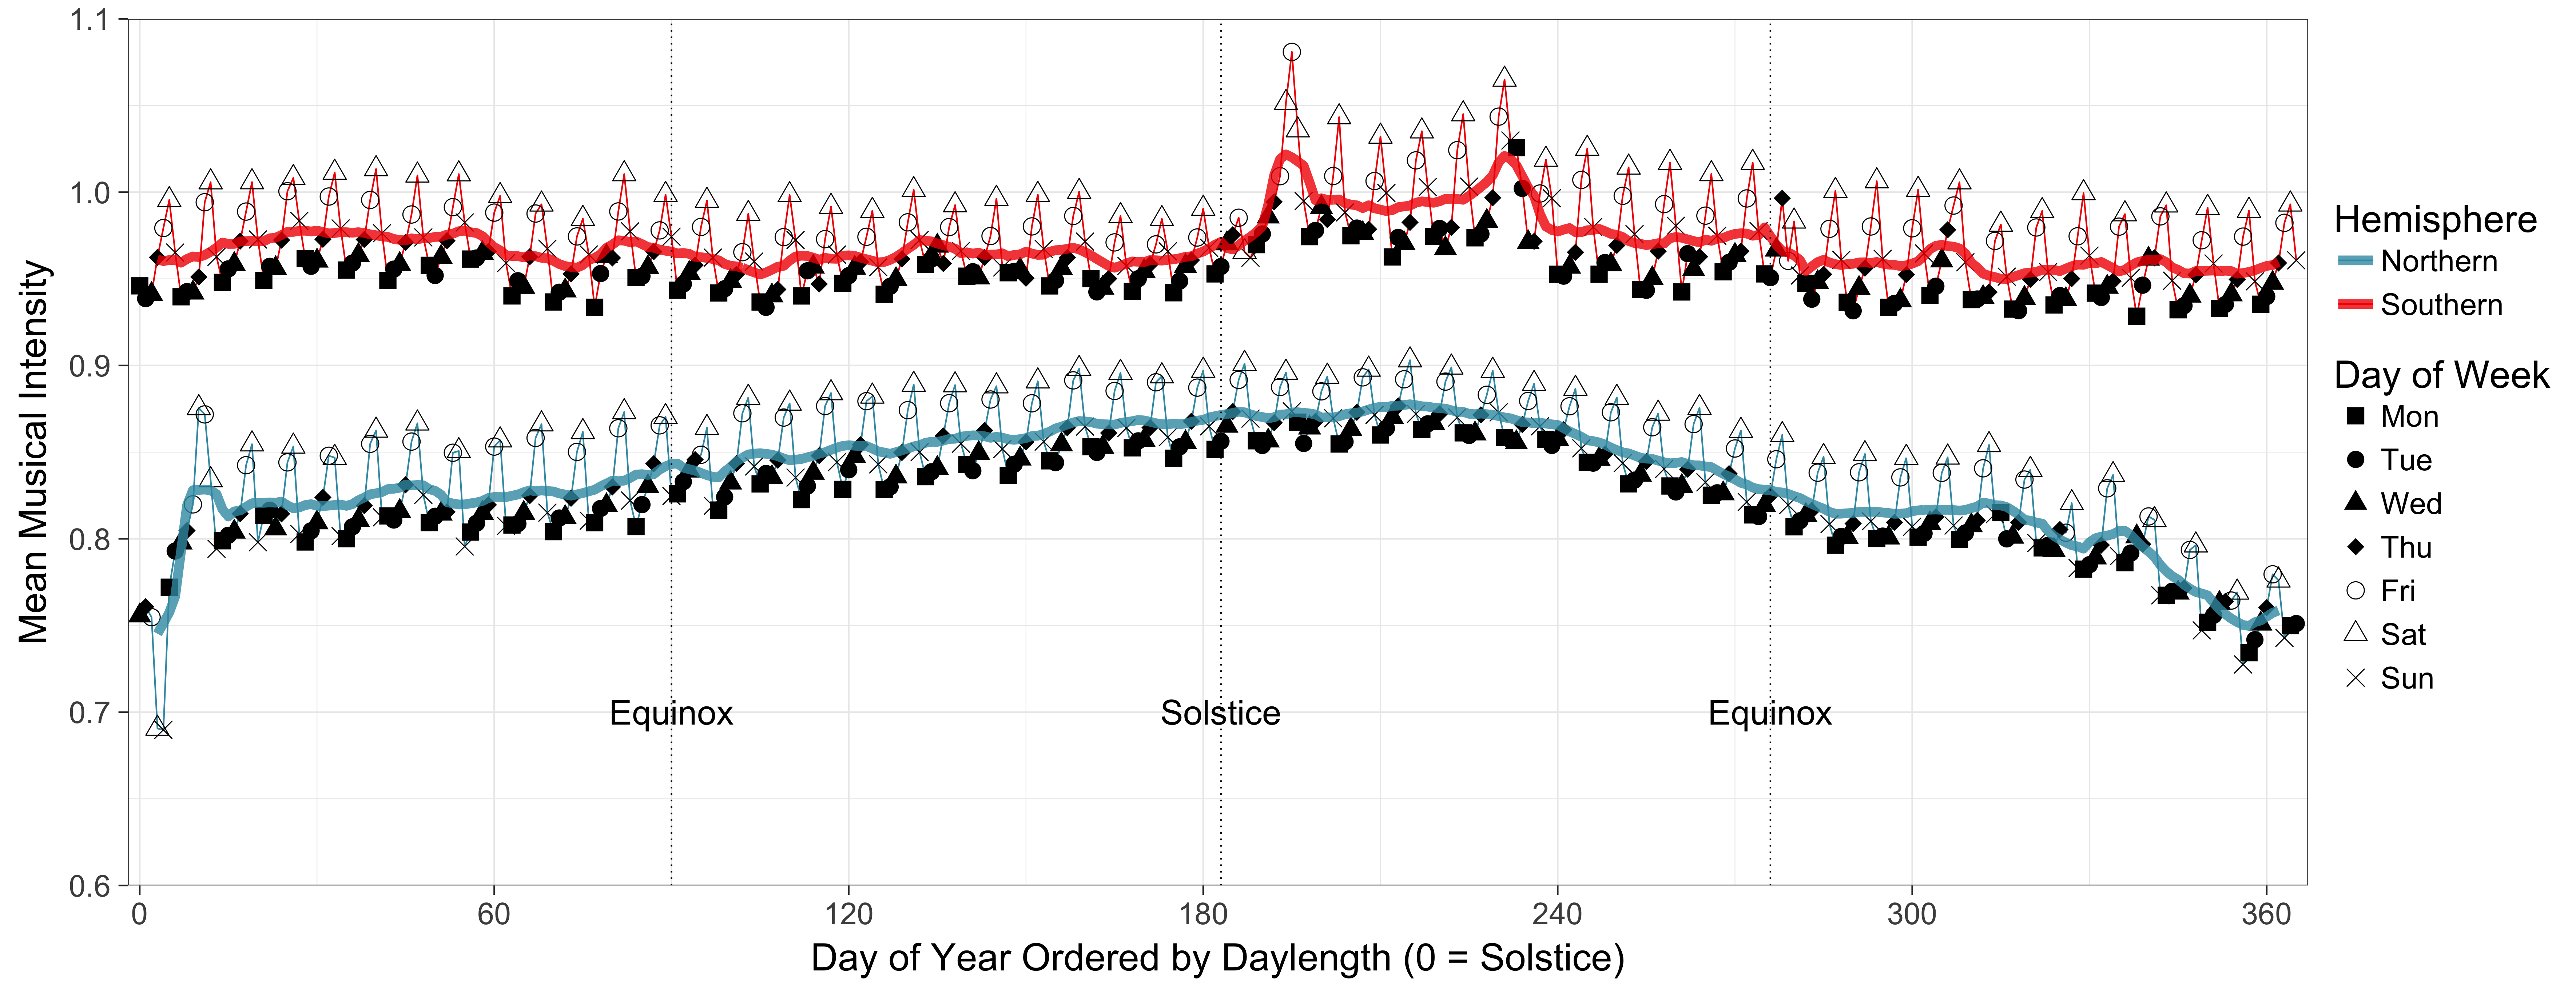

In [4]:
tmp <- read.csv("../data/intensity/doy_hemispherexdow.csv", header=TRUE)
tmp$dow <- lubridate::wday(as.Date(tmp$doy-1, origin = "2016-01-01"), label=TRUE)
tmp$dow <- factor(tmp$dow,
                  levels = c("Mon","Tue", "Wed", "Thu", "Fri", "Sat", "Sun"),
                  ordered = TRUE)
tmp$shortest_day_solstice[tmp$Hemisphere=="Northern"] <- solstice_dec
tmp$shortest_day_solstice[tmp$Hemisphere=="Southern"] <- solstice_jun
tmp$adjusted_doy <- as.numeric(tmp$doy) - as.numeric(tmp$shortest_day_solstice)
my.cols = c("#3b9ab2","#f21a00")

## Compute the adjusted days of the year ##
setDT(tmp)[, adjusted_doy:=ifelse(adjusted_doy < 0,
                                  adjusted_doy + abs(min(adjusted_doy)) + max(adjusted_doy[adjusted_doy > 0]) + 1,
                                  adjusted_doy),
           by=Hemisphere]

## Compute the centered moving average for the trend line ##
cma <- setDT(tmp)[, within_variation, keyby="adjusted_doy,Hemisphere"]
setDT(cma)[, cma:=filter(within_variation, rep(1/7,7), sides=2), by="Hemisphere"]

p_hemispherexdow <- ggplot() + 
  geom_line(data=tmp, aes(x=adjusted_doy, y=within_variation, color=Hemisphere)) +
  geom_point(data=tmp, aes(x=adjusted_doy, y=within_variation, shape=dow), size=5) +
  scale_shape_manual(values=c(15, 16, 17, 18, 1, 2, 4)) +
  geom_line(data=cma, aes(x=adjusted_doy, y=cma, color=Hemisphere), size=3, alpha=0.8) +
  scale_color_manual(values=my.cols) +
  geom_vline(xintercept=c(90,183,276), color="black", linetype="dotted") + 
  geom_text(aes(x=90, y=0.7), label="Equinox", color="black", angle=0, size=8) +
  geom_text(aes(x=276, y=0.7), label="Equinox", color="black", angle=0, size=8) +
  geom_text(aes(x=183, y=0.7), label="Solstice", color="black", angle=0, size=8) +
  labs(x="Day of Year Ordered by Daylength (0 = Solstice)", y=paste("Mean Musical Intensity"), color="Hemisphere", shape="Day of Week") +
  scale_y_continuous(limits=c(0.6,1.1), expand=c(0,0), breaks=seq(0.6,1.1,0.1),
                     labels=c(seq(0.6,0.9,0.1),"1.0",1.1)) +
  scale_x_continuous(limits=c(-2,367), expand=c(0,0), breaks=0:365*60,
                     labels=0:365*60) +
  theme_bw(base_size=25) +
  theme(legend.key.size=unit(2, "lines"),
        legend.background=element_rect(fill=alpha("white", 0))) +
  guides(linetype=guide_legend(override.aes=list(size=2)))

p_hemispherexdow

pdf(file="../output/sfig2.pdf", width=23.6, height=9.1)
print(p_hemispherexdow)
dev.off()